In [39]:
# 1. Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl as pxl
from datetime import datetime

# 1. Charger toutes les feuilles du fichier Excel et Convertir les valeurs manquantes en NaN 
excel_file = "data/sales.xlsx"
sheets = pd.read_excel(excel_file, sheet_name=None, na_values=["?", "N/A", "Not Available"]  )


# 2. Initialiser une liste pour stocker chaque DataFrame
df_list = []

# 3. Parcourir chaque feuille pour  Fusionner toutes les feuilles en un seul DataFrame
for sheet_name, df in sheets.items():
    df["Source_sheet"] = sheet_name
    df_list.append(df)  # Ajouter le DataFrame à la liste

# 4. Fusionner toutes les feuilles
df_combined=pd.concat(df_list,ignore_index=True)


# Convertir la date
df_combined['OrderDate'] = pd.to_datetime(df_combined['OrderDate'], errors='coerce')

# Supprimer les lignes où la date est NaT
df_sales = df_combined[df_combined['OrderDate'].notna()]

# Étendre les dates de début à fin
start_date = df_combined['OrderDate'].min()
end_date = df_combined['OrderDate'].max()

# Générer toutes les dates jour par jour
date_table = pd.DataFrame({
    'Date': pd.date_range(start=start_date, end=end_date)
})

# Ajouter les colonnes utiles
date_table['Year'] = date_table['Date'].dt.year
date_table['Month'] = date_table['Date'].dt.month
date_table['MonthName'] = date_table['Date'].dt.strftime('%B')  
date_table['Quarter'] = date_table['Date'].dt.quarter
date_table['Weekday'] = date_table['Date'].dt.day_name()

# Vérification : pas de valeurs manquantes et Date unique
assert date_table['Date'].is_unique
assert not date_table.isnull().values.any()


# # Supprimer les doublants
# df_combined.drop_duplicates(inplace=True)

# # Supprimer les ligne  avec au moins une valeurs manquante
# df_combined.dropna(inplace=True)

# Création des colonnes calculées dans le DataFrame

df_combined["Sales"] = df_combined["Order Quantity"] * df_combined["Unit Selling Price"]
df_combined["Cost"] = df_combined["Order Quantity"] * df_combined["Unit Cost"]
df_combined["Profit"] = df_combined["Sales"] - df_combined["Cost"]

#  Ajout des colonnes 'Year' et 'Month' pour les comparaisons temporelles
df_combined['Year'] = df_combined['OrderDate'].dt.year
df_combined['Month'] = df_combined['OrderDate'].dt.month



# ***** Créations des expressions  de mesures ******

# 1. Total sales 
total_sales = df_combined['Sales'].sum()
print("Total des ventes :", round(total_sales, 2))

# 2.Total profit
total_profit = df_combined['Profit'].sum()
print("Total Profit:", total_profit)

# 3. Total Order Quantity
total_orders = df_combined['Order Quantity'].sum()
print("Nombre de commandes :", total_orders)


# 4. Total Cost
total_cost = df_combined["Cost"].sum()
print("Total cost  :", total_cost)

# 5. Profit Margin %
profit_margin = (total_profit / total_sales) * 100 if total_sales != 0 else 0
print("Total margin:", profit_margin)


# Agréger les données par année
yearly_kpis = df_combined.groupby('Year').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Order Quantity': 'sum'
}).reset_index()

# Calculer les variations entre années
yearly_kpis['Sales_PY'] = yearly_kpis['Sales'].shift(1)
yearly_kpis['Profit_PY'] = yearly_kpis['Profit'].shift(1)
yearly_kpis['OrderQty_PY'] = yearly_kpis['Order Quantity'].shift(1)

# Variation absolue
yearly_kpis['Sales_Var'] = yearly_kpis['Sales'] - yearly_kpis['Sales_PY']
yearly_kpis['Profit_Var'] = yearly_kpis['Profit'] - yearly_kpis['Profit_PY']
yearly_kpis['OrderQty_Var'] = yearly_kpis['Order Quantity'] - yearly_kpis['OrderQty_PY']

# Variation en pourcentage
yearly_kpis['Sales_Var_%'] = (yearly_kpis['Sales_Var'] / yearly_kpis['Sales_PY']) * 100
yearly_kpis['Profit_Var_%'] = (yearly_kpis['Profit_Var'] / yearly_kpis['Profit_PY']) * 100
yearly_kpis['OrderQty_Var_%'] = (yearly_kpis['OrderQty_Var'] / yearly_kpis['OrderQty_PY']) * 100




Total des ventes : 154573140.6
Total Profit: 57789142.907000005
Nombre de commandes : 67579.0
Total cost  : 96783997.693
Total margin: 37.38627725533837


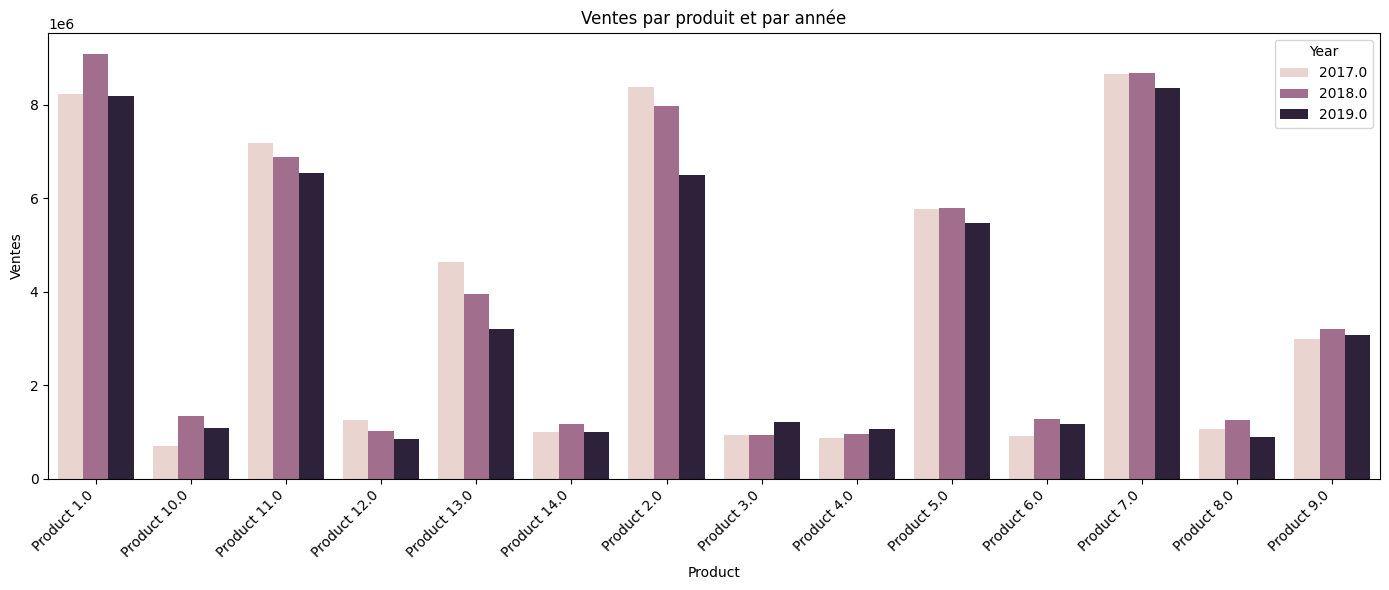

In [88]:

# **** 1.Ventes par produit et comparaison avec année précédente

# 1. Ajouter un nom avant chaque indice (ex : "Produit 101")
df_combined['Produit Index'] = "Product " + df_combined['Product Description Index'].astype(str)

# 2. Agréger les ventes par produit formaté et par année
sales_by_product_year = df_combined.groupby(['Produit Index', 'Year'])['Sales'].sum().reset_index()

# 3. Visualisation
plt.figure(figsize=(14, 6))
sns.barplot(data=sales_by_product_year, x='Produit Index', y='Sales', hue='Year')
plt.xticks(rotation=45, ha='right')
plt.title("Ventes par produit et par année")
plt.xlabel("Product")
plt.ylabel("Ventes")
plt.tight_layout()
plt.show()



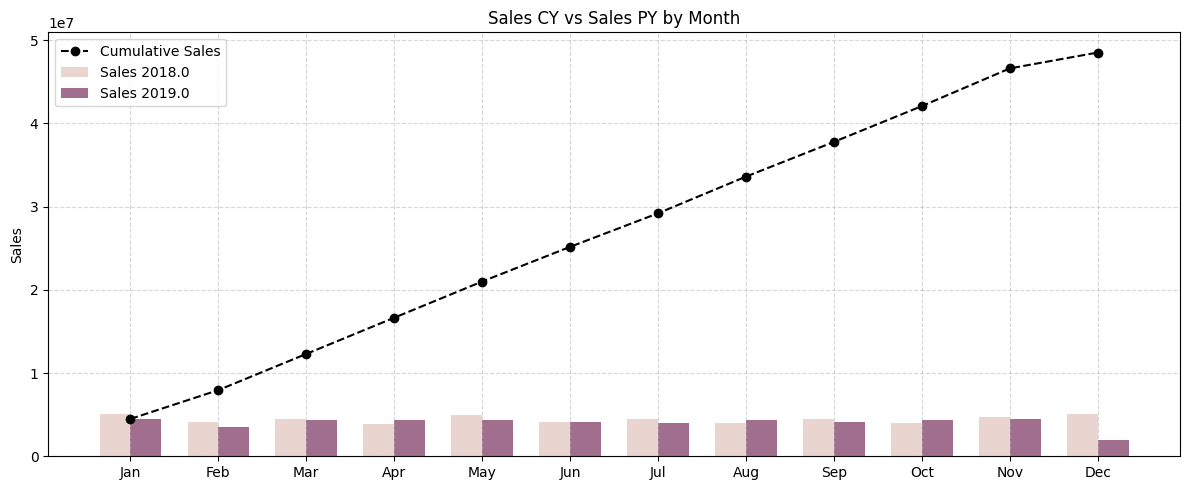

In [89]:
# #2. Ventes par mois et comparaison avec année précédente

# Extraire l'année la plus récente et la précédente
latest_year = df_combined['Year'].max()
previous_year = latest_year - 1

# Filtrer les données pour ces deux années
df_months = df_combined[df_combined['Year'].isin([previous_year, latest_year])]

# Regrouper par mois et année
monthly_sales = df_months.groupby(['Month', 'Year'])['Sales'].sum().unstack()

# Réordonner les mois
monthly_sales = monthly_sales.sort_index()

# Création du graphique
fig, ax = plt.subplots(figsize=(12, 5))

x = np.arange(1, 13)  # mois de 1 à 12
bar_width = 0.35

# Barres pour chaque année
ax.bar(x - bar_width/2, monthly_sales[previous_year], width=bar_width, label=f'Sales {previous_year}', color='#E9D4D0')
ax.bar(x + bar_width/2, monthly_sales[latest_year], width=bar_width, label=f'Sales {latest_year}', color='#A16F8D')

# Ligne cumulée (par exemple pour l'année actuelle)
cumulative_sales = monthly_sales[latest_year].cumsum()
ax.plot(x, cumulative_sales, color='black', linestyle='--', marker='o', label='Cumulative Sales')

# Personnalisation
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticks(x)
ax.set_xticklabels(month_labels)
ax.set_title("Sales CY vs Sales PY by Month")
ax.set_ylabel("Sales")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


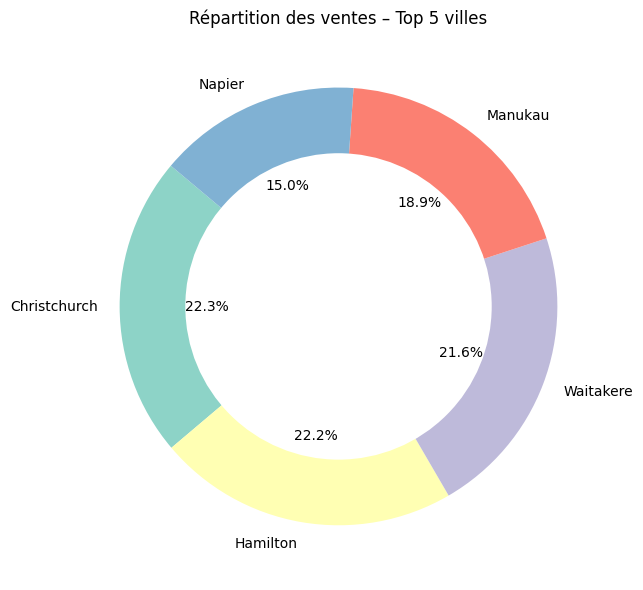

In [ ]:

# Récupération des feuilles nécessaires
df_sales_orders = sheets['Sales Orders']
df_regions = sheets['Regions']


# Jointure avec les noms de villes
df_merged = pd.merge(df_sales_orders, df_regions, left_on="Delivery Region Index", right_on="Index", how="left")

# Regrouper les ventes par ville et garder les 5 premières
top_5_cities = df_merged.groupby('City')['Sales'].sum().sort_values(ascending=False).head(5)

# Création du donut chart (sans "Autres")
fig, ax = plt.subplots(figsize=(8, 6))
colors = sns.color_palette('Set3', len(top_5_cities))
wedges, texts, autotexts = ax.pie(
    top_5_cities,
    labels=top_5_cities.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops=dict(width=0.4)
)

# Cercle central pour l’effet "donut"
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Titre
ax.set_title("Répartition des ventes – Top 5 villes")
plt.tight_layout()
plt.show()


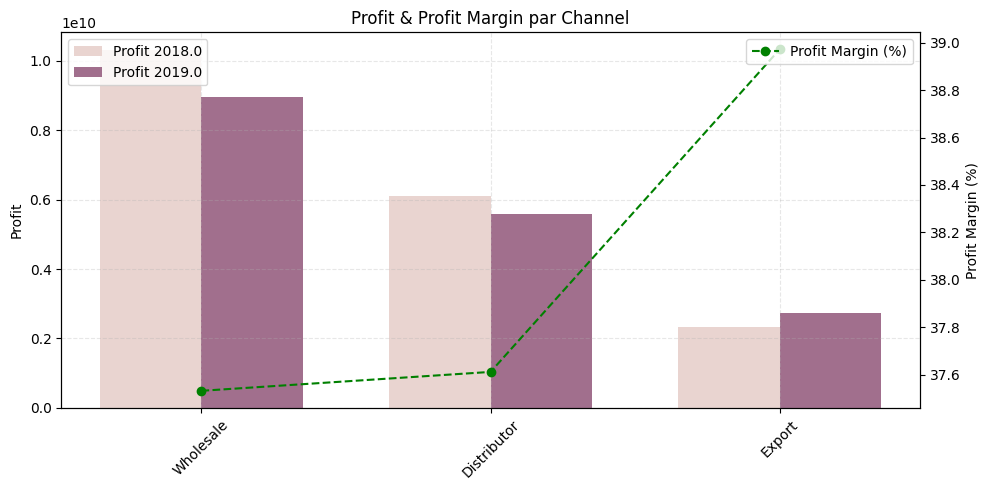

In [ ]:
# 4. Comparez le bénéfice par canal avec le bénéfice de l’année précédente

# Filtrer les années concernées
latest_year = df_combined['Year'].max()
previous_year = latest_year - 1
df_profit = df_combined[df_combined['Year'].isin([previous_year, latest_year])]

# Agréger les profits, ventes et marges par Channel & Year
agg = df_profit.groupby(['Channel', 'Year']).agg({
    'Profit': 'sum',
    'Sales': 'sum'
}).reset_index()

# Pivot pour avoir les profits CY/PY côte à côte
profit_pivot = agg.pivot(index='Channel', columns='Year', values='Profit').dropna()
# 
# Calcul de la profit margin pour l'année actuelle
sales_pivot = agg.pivot(index='Channel', columns='Year', values='Sales').dropna()
profit_margin = (profit_pivot[latest_year] / sales_pivot[latest_year]) * 100

# Tri des canaux par profit actuel
profit_pivot = profit_pivot.sort_values(by=latest_year, ascending=False)
profit_margin = profit_margin.loc[profit_pivot.index]

# Affichage
fig, ax1 = plt.subplots(figsize=(10, 5))

x = np.arange(len(profit_pivot))
bar_width = 0.35

# Barres pour Profit PY et CY
ax1.bar(x - bar_width/2, profit_pivot[previous_year], width=bar_width, label=f'Profit {previous_year}', color='#E9D4D0')
ax1.bar(x + bar_width/2, profit_pivot[latest_year], width=bar_width, label=f'Profit {latest_year}', color='#A16F8D')
ax1.set_ylabel('Profit')
ax1.set_xticks(x)
ax1.set_xticklabels(profit_pivot.index, rotation=45)
ax1.legend(loc='upper left')

# Deuxième axe pour la Profit Margin (ligne)
ax2 = ax1.twinx()
ax2.plot(x, profit_margin, color='green', marker='o', linestyle='--', label='Profit Margin (%)')
ax2.set_ylabel('Profit Margin (%)')
ax2.legend(loc='upper right')

# Titre et style
plt.title('Profit & Profit Margin par Channel')
ax1.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


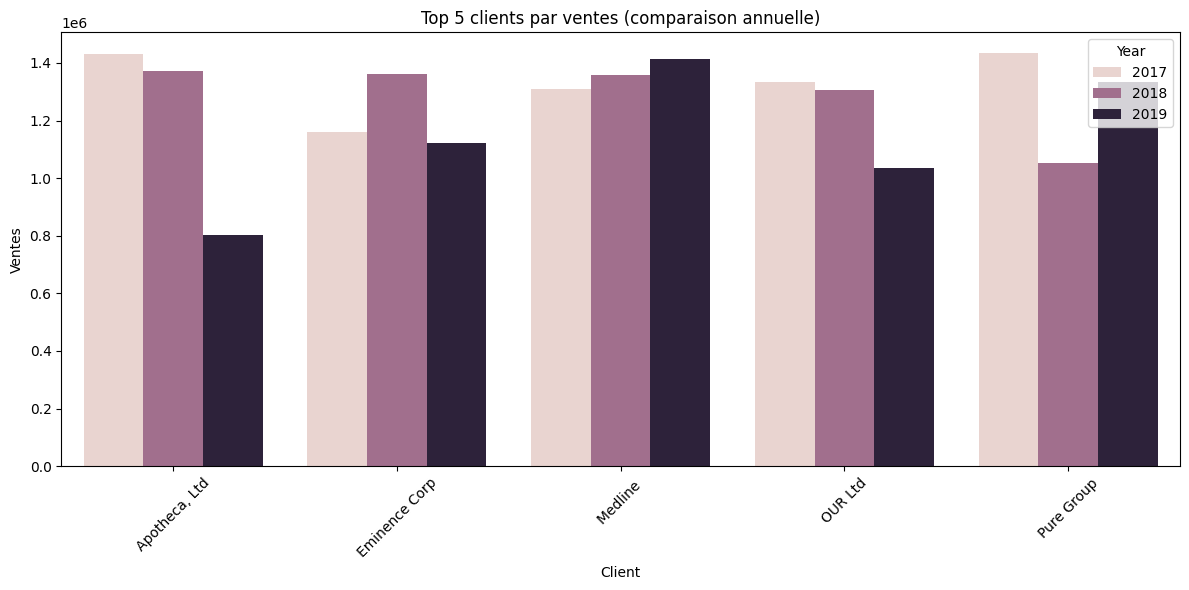

In [ ]:
# #Top 5 des clients (ventes) et comparaison avec année précédente


sales_orders = sheets['Sales Orders']
customers = sheets['Customers']

df_joined = pd.merge(
    sales_orders, 
    customers, 
   left_on="Customer Name Index", 
   right_on="Customer Index", 
   how="left"
)

df_joined['OrderDate'] = pd.to_datetime(df_joined['OrderDate'], errors='coerce')
df_joined = df_joined[df_joined['OrderDate'].notna()]
df_joined['Year'] = df_joined['OrderDate'].dt.year
df_joined["Sales"] = df_joined["Order Quantity"] * df_joined["Unit Selling Price"]

client_year_sales = df_joined.groupby(['Customer Names', 'Year'])['Sales'].sum().reset_index()

top_clients_total = client_year_sales.groupby('Customer Names')['Sales'].sum().nlargest(5).index
top_clients_filtered = client_year_sales[client_year_sales['Customer Names'].isin(top_clients_total)]

plt.figure(figsize=(12, 6))
sns.barplot(data=top_clients_filtered, x='Customer Names', y='Sales', hue='Year')
plt.title("Top 5 clients par ventes (comparaison annuelle)")
plt.ylabel("Ventes")
plt.xlabel("Client")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




C:\Users\hp\AppData\Local\Temp\ipykernel_34104\4056625576.py:15: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\ACTIVITES_PRATIQUE\PYTHON POUR DS\TP\venv_tp\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


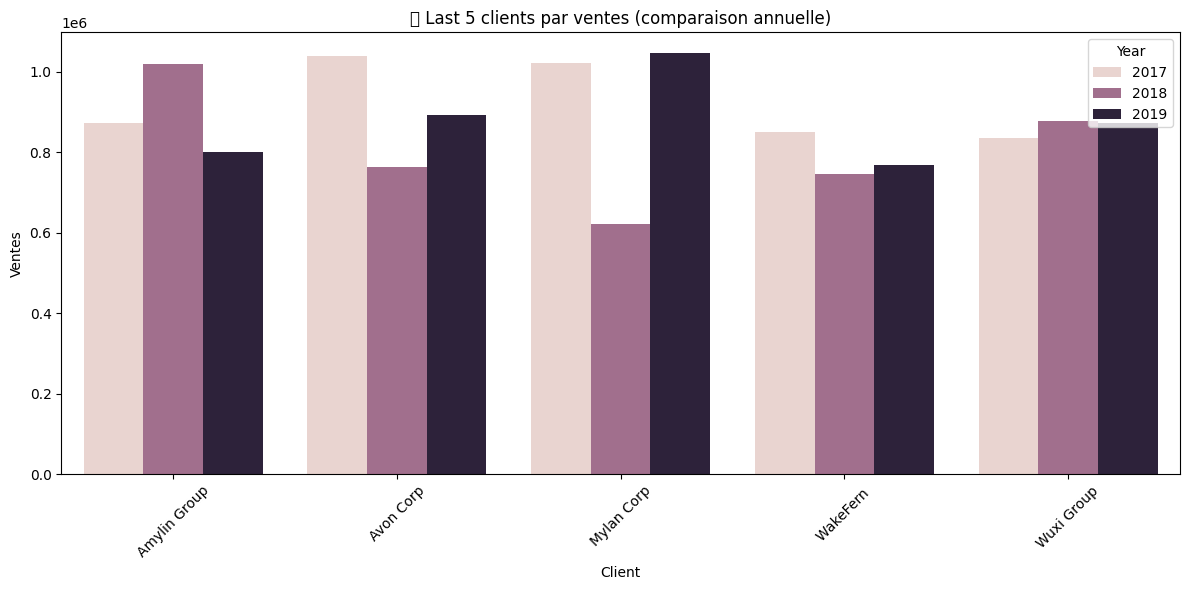

In [ ]:
# Last 5 des Ventes par client et comparaison avec les ventes de l’année dernière


total_sales_by_client = client_year_sales.groupby('Customer Names')['Sales'].sum()
last_5_clients = total_sales_by_client.nsmallest(5).index

last_clients_filtered = client_year_sales[client_year_sales['Customer Names'].isin(last_5_clients)]

plt.figure(figsize=(12, 6))
sns.barplot(data=last_clients_filtered, x='Customer Names', y='Sales', hue='Year')
plt.title("Last 5 clients par ventes (comparaison annuelle)")
plt.ylabel("Ventes")
plt.xlabel("Client")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



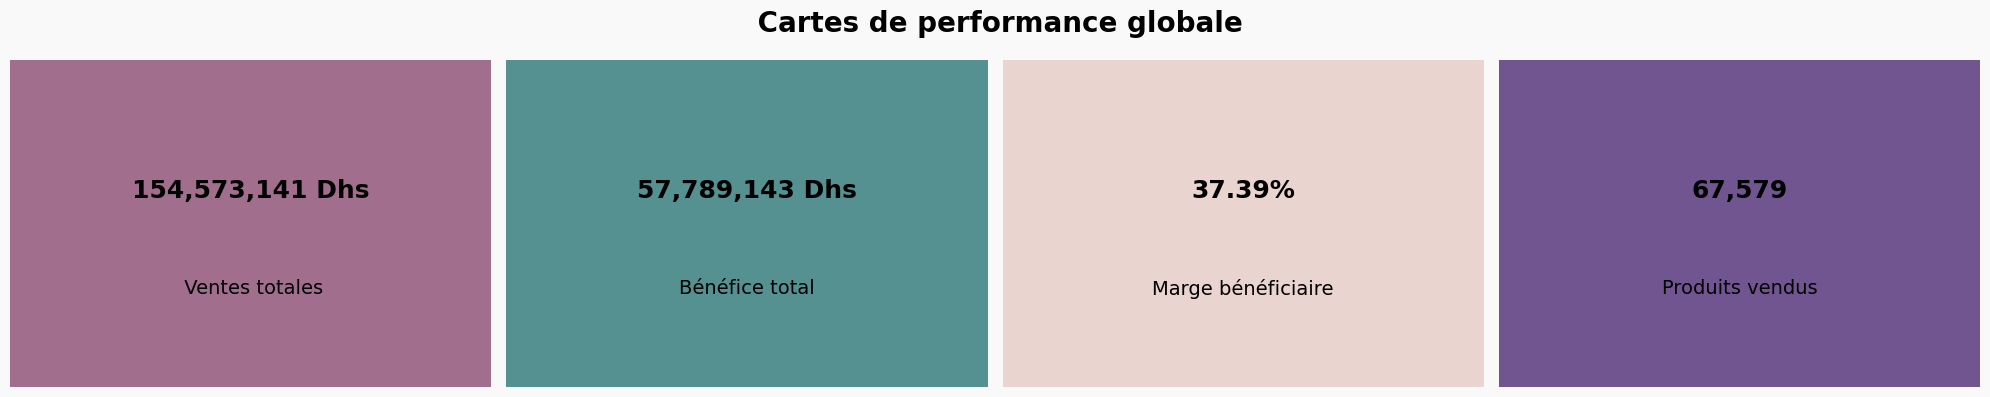

In [ ]:

# Des cartes pour les ventes, les bénéfices, la marge bénéficiaire et les produits vendus

# Visualisation des KPI sous forme de cartes
fig, axs = plt.subplots(1, 4, figsize=(20, 4), facecolor='#f9f9f9')

kpis = {
    " Ventes totales": f"{total_sales:,.0f} Dhs",
    "Bénéfice total": f"{total_profit:,.0f} Dhs",
    "Marge bénéficiaire": f"{profit_margin:.2f}%",
    "Produits vendus": f"{int(total_orders):,}"
}

colors = ['#A16F8D', '#559191', '#E9D4D0', '#715591']

for ax, (title, value), color in zip(axs, kpis.items(), colors):
    ax.text(0.5, 0.6, value, fontsize=18, fontweight='bold', ha='center', va='center')
    ax.text(0.5, 0.3, title, fontsize=14, ha='center', va='center')
    ax.set_facecolor(color)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.suptitle(" Cartes de performance globale", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()
